# Experiment Notebook for Classification with Perceptron and SAMME Adaboost

**Key Points:**
 - We load the MNIST (8x8) digits dataset via `sklearn.load_digits`.
 - We flatten each 8x8 image to a length-64 feature vector.
 - We one-hot encode the targets for clarity, although the perceptron in "perceptron.py" might only need integer labels.
 - We split data into train, validation, and test sets.
 - We create a "factory" function to build a multi-class Perceptron (our "weak learner").
 - We wrap the Perceptron with a SAMME (multi-class AdaBoost) loop, so each round re-fits a new Perceptron focusing on misclassified examples.

In [1]:
from perceptron import Perceptron
from SAAME_adaboost import SAMME_Adaboost  
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import random, math

## 1. Load the Digits Dataset
The digits dataset has 1797 samples of handwritten digits 0-9.
Each is an 8x8 image, which we'll flatten into a 64-length vector.

In [2]:
digits = load_digits()
X = digits.images  # Shape (1797, 8, 8)
y = digits.target  # Shape (1797,)

print("Original shape of X (images):",
       X.shape)
print("Shape of y (labels):", y.shape)
print("Digit classes:", np.unique(y))

Original shape of X (images): (1797, 8, 8)
Shape of y (labels): (1797,)
Digit classes: [0 1 2 3 4 5 6 7 8 9]


**Flatten** the (8,8) into a 64-D feature:

In [3]:
N, H, W = X.shape
X = X.reshape(N, H*W)  # Now X is shape (1797, 64)
print("Reshaped X for perceptron input:", X.shape)

Reshaped X for perceptron input: (1797, 64)


## 2. Train / Validation / Test Split
We do:
- ~60% total for train
- ~15% for validation
- ~15% for final test



In [4]:

total_samples = X.shape[0]
test_size = 0.15  # fraction of total data for  test set
val_size = 0.15   # fraction of total data for  validation set

# Remaining fraction for training
train_size = 1 - (test_size + val_size)  

# first split
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42, stratify=y
)

# second split: spliting training-validation set into training and validation
relative_val_size = val_size / (train_size + val_size)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=relative_val_size, random_state=42, stratify=y_train_val
)

print(f"Total samples: {total_samples}")
print(f"Training set size: {X_train.shape[0]} ({(X_train.shape[0] / total_samples):.2%})")
print(f"Validation set size: {X_val.shape[0]} ({(X_val.shape[0] / total_samples):.2%})")
print(f"Test set size: {X_test.shape[0]} ({(X_test.shape[0] / total_samples):.2%})")


Total samples: 1797
Training set size: 1257 (69.95%)
Validation set size: 270 (15.03%)
Test set size: 270 (15.03%)


## 3. Perceptron Factory & SAMME Setup
We define a small "factory" function that returns a fresh Perceptron instance.
Then we pass that to our SAMME_Adaboost as the base learner.



In [5]:
def perceptron_factory():
    return Perceptron(
        n_features=64,
        eta=0.1,      
        max_iter=2)  

### 3.2 Instantiate SAMME Adaboost

1. Trains a new Perceptron on a reweighted data points.
2. Measures the weighted error.
3. Updates weights & re-normalizes them.

In [6]:
model = SAMME_Adaboost(
    n_rounds=100, 
    base_learner_factory=perceptron_factory,
    n_classes=10
)


**Note**: If you had a validation set, you might pass it in for monitoring or early stopping.
Our `fit` method might allow `(X_val, y_val)` as optional arguments to track validation metrics.
That depends on how your `SAMME_Adaboost` is coded internally.

In [7]:
model.fit(X_train, y_train,X_val,y_val)  


Round 1: Weighted Train Err=0.0724, Train Acc=0.9276, Val Err=0.1037, Val Acc=0.8963
Round 2: Weighted Train Err=0.5820, Train Acc=0.3309, Val Err=0.1037, Val Acc=0.8963
Round 3: Weighted Train Err=0.3731, Train Acc=0.3190, Val Err=0.1037, Val Acc=0.8963
Round 4: Weighted Train Err=0.3767, Train Acc=0.3771, Val Err=0.1926, Val Acc=0.8074
Round 5: Weighted Train Err=0.3978, Train Acc=0.5187, Val Err=0.1333, Val Acc=0.8667
Round 6: Weighted Train Err=0.3825, Train Acc=0.3341, Val Err=0.1259, Val Acc=0.8741
Round 7: Weighted Train Err=0.4600, Train Acc=0.5036, Val Err=0.1037, Val Acc=0.8963
Round 8: Weighted Train Err=0.4330, Train Acc=0.4901, Val Err=0.1074, Val Acc=0.8926
Round 9: Weighted Train Err=0.3637, Train Acc=0.4837, Val Err=0.1037, Val Acc=0.8963
Round 10: Weighted Train Err=0.4163, Train Acc=0.4837, Val Err=0.0963, Val Acc=0.9037
Round 11: Weighted Train Err=0.5962, Train Acc=0.5282, Val Err=0.0963, Val Acc=0.9037
Round 12: Weighted Train Err=0.4700, Train Acc=0.3946, Val Err=

Plotting  Metrics


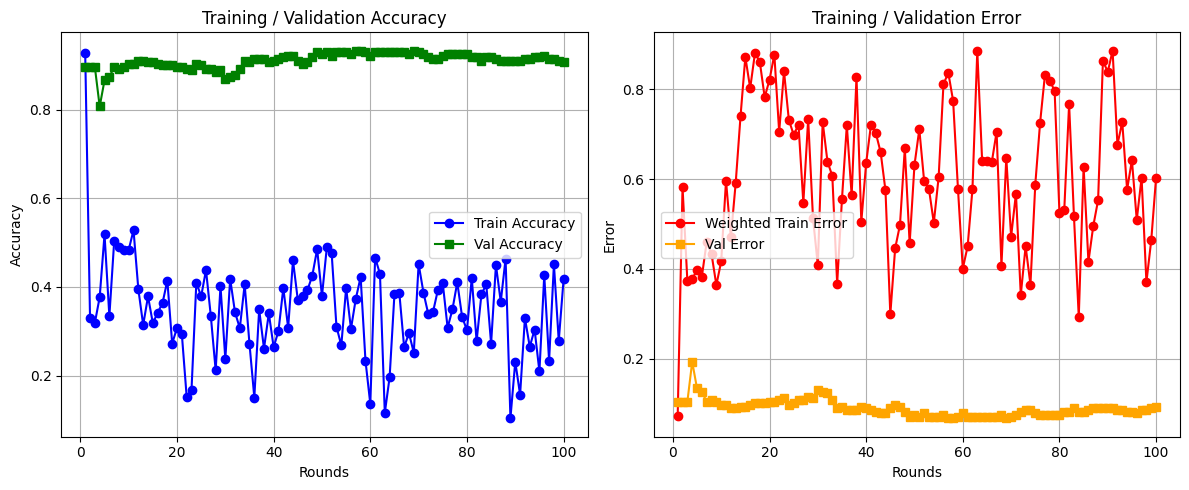

In [8]:
model.plot_metrics()


In [9]:
best_stage=np.argmax(model.validation_accuracies)
best_stage

56

## 4. Evaluate on the Test Set
We'll scale the test data using the same scaler (fit on train_val).

In [13]:

y_test_pred = model.predict(X_test,best_stage)

test_acc = accuracy_score(y_test, y_test_pred)
test_f1_micro = f1_score(y_test, y_test_pred, average='micro')
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')

print(f"Test Accuracy: {test_acc * 100:.3f}%")
print(f"Test Micro-F1 Score: {test_f1_micro:.4f}")
print(f"Test Macro-F1 Score: {test_f1_macro:.4f}")

Test Accuracy: 87.778%
Test Micro-F1 Score: 0.8778
Test Macro-F1 Score: 0.8800


### Confusion Matrix
This helps us see where the model confuses one digit with another.

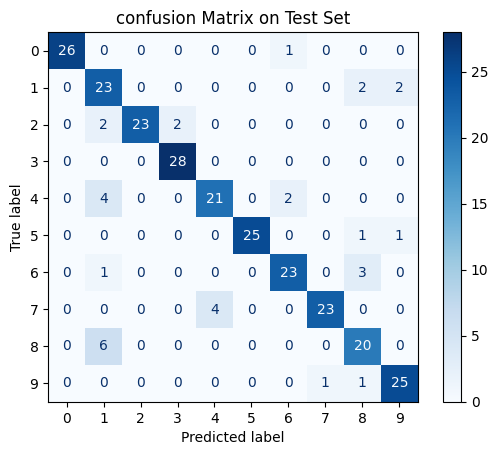

In [11]:
cm = confusion_matrix(y_test, y_test_pred, labels=range(model.n_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(model.n_classes))

disp.plot(cmap='Blues')

plt.title("confusion Matrix on Test Set")

plt.show()

## 5. Showing a Few Test Samples

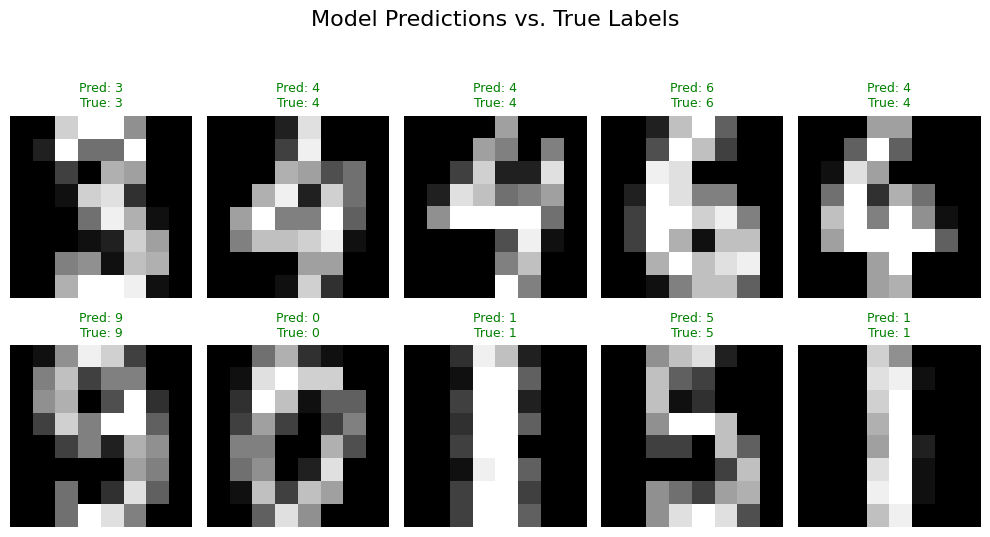

In [12]:
num_samples = 10
random.seed(42)
indices = random.sample(range(X_test.shape[0]), num_samples)
X_sample = X_test[indices]
y_sample_true = y_test[indices]
y_sample_pred = y_test_pred[indices]

image_shape = (8, 8)  # original shape for visualization

max_per_row = 5
num_rows = math.ceil(num_samples / max_per_row)
fig, axes = plt.subplots(num_rows, max_per_row, figsize=(max_per_row * 2, num_rows * 3))
axes = axes.flatten()

for i in range(num_samples):
    ax = axes[i]
    img = X_sample[i].reshape(image_shape)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    
    correct = (y_sample_pred[i] == y_sample_true[i])
    title_color = 'green' if correct else 'red'
    ax.set_title(
        f"Pred: {y_sample_pred[i]}\nTrue: {y_sample_true[i]}",
        color=title_color, fontsize=9
    )

plt.suptitle("Model Predictions vs. True Labels", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Summary of Modifications and Commentary

1. **Classical Perceptron**:
   - The core Perceptron update is: if a sample (x_i, y_i) is misclassified, then `w <- w + alpha * sample_weight[i] * x_i`.
   - In a pure theoretical setting, we'd use a `while True` loop and stop when we see no errors. In practice, we limit epochs (`max_iter`) for real data that may not be separable.

2. ** Perceptron**:
   - Our code uses `n_classes=10` and a direct multi-class scheme inside `perceptron.py`.
   - Each pass updates the relevant class weights if a sample is predicted incorrectly.

3. **SAMME (AdaBoost)**:
   - We wrap the Perceptron in an AdaBoost loop for multi-class problems.
   - Each round, we train a new Perceptron on a reweighted sample, so it focuses on previously misclassified points more strongly.
   - Then we compute a coefficient α^(m) based on weighted error, and update sample weights.

4. **Train/Val/Test**:
   - We split the dataset and scaled the features.
   - If your code implements early stopping or hyperparameter tuning, you'd use a separate validation set.
   - We eventually test on the hold-out test set to see final performance.

5. **Result**:
   - We measure accuracy, F1 scores, and display a confusion matrix.
   - We also look at sample predictions to see how well the model does visually.

The above comments clarify how this code relates to the classical perceptron pseudocode **and** how we adapt it for multi-class Adaboost in a practical scenario.